<a id="top"></a>
# Gradient Boosted Trees model for default prediction (proof of concept)
Mykhaylo Salnykov <br>
v. 1.5<br>
Created: 19-10-2019<br>
Last modified: 20-12-2019<br>
<br>
This code is designed to establish business case on using predictive analytics' Gradient Boosted Tree (GBT) machine learning tool to predict defaults.<br>
<br>
This code demonstrates superior performance of GBT model as compared to Logistic Regression model both in terms of model metrics and using the Business Case <br>
<br>
The case shows that an un-tuned model allows to reach an estimated 110% net profit increase on the test sample as compared to current decision making approach and 50% increase increase in case of Logistic Regression.<br>
<br>
This proof of concept is prepared on the Client's request to explore potential of using Python-based machine learning models to predict loan defaults and uses open masked data. Any similarities to any Client's real data set are purely accidental.<br>
<br>
<b>Jump directly to</b><br>
[Data Load and Cleanup](#Data-Load-and-Cleanup)<br>
[GBT Model Run](#GBT-model-run)<br>
[Model Results](#Model-results)<br>
[Business Case](#Business-case)

[[to top]](#top)<br><br>

<h2><a id="Data-Load-and-Cleanup">Data Load and Cleanup</a></h2><br>


In [1]:
import pandas as pd
import numpy as np

from csv_import import data #this is raw data
from csv_import import descriptive #this is function giving descriptive statistics of the dataframe

# Display information about the dataframe and missing values
print('CSV file with {} rows imported'.format(data.shape[0]))
print('{} data instances for {} entries is missing'.
      format(data.isnull().sum().sum(),
             data[data.isnull().any(axis=1)].shape[0]))
print('')
print ('Original data')
print('')
print (descriptive(data))
print('')

CSV file with 32581 rows imported
4011 data instances for 3943 entries is missing

Original data

                               Type      N  Missing      Avg      Med     Min         Max
person_age                    int64  32581        0     27.7     26.0    20.0       144.0
person_income                 int64  32581        0 66,074.8 55,000.0 4,000.0 6,000,000.0
person_home_ownership        object  32581        0                                      
person_emp_length           float64  31686      895      4.8      4.0     0.0       123.0
loan_intent                  object  32581        0                                      
loan_grade                   object  32581        0                                      
loan_amnt                     int64  32581        0  9,589.4  8,000.0   500.0    35,000.0
loan_int_rate               float64  29465     3116     11.0     11.0     5.4        23.2
loan_status                   int64  32581        0      0.2      0.0     0.0         1.0
lo

This dataset has three problems:

1. person_age and person_emp_length has some obvious outliers as max(person_age)=144 and max(person_emp_length)=123. These are possibly due to incorrectly entered data and must be studied
2. person_emp_length and loan_int_rate contains missing values. Missing values negativly affect performance of the models and must be cleaned
3. some data are object type. We need to convert it to dummies for GBT model.

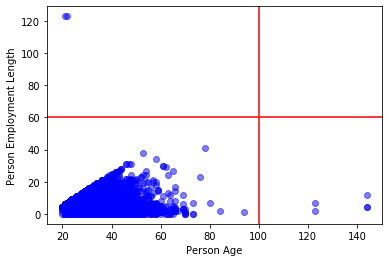

In [2]:
import matplotlib.pyplot as plt

# Study scatter of person_age and person_emp_length because it may contain identifiable outliers
plt.scatter(data['person_age'], data['person_emp_length'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Person Employment Length")

# It is highly unlikely that a borrower has work experience above 60 years or age above 100 years. Hence, observations
# with values above these will be considered outliers
plt.axvline(x=100, color='red')
plt.axhline(y=60, color='red')
plt.show()

In [3]:
# Remove obvious outliers: max_age=100, max_emp_length=60
max_age=100
max_emp_length=60
indices=data.query('person_age>{} or person_emp_length>{}'.format(max_age, max_emp_length)).index.tolist()
data_clean = data.drop(indices)
print ('Dataset free from obvious outliers')
print('')
print (descriptive(data_clean))
print('')

Dataset free from obvious outliers

                               Type      N  Missing      Avg      Med     Min         Max
person_age                    int64  32574        0     27.7     26.0    20.0        94.0
person_income                 int64  32574        0 65,878.5 55,000.0 4,000.0 2,039,784.0
person_home_ownership        object  32574        0                                      
person_emp_length           float64  31679      895      4.8      4.0     0.0        41.0
loan_intent                  object  32574        0                                      
loan_grade                   object  32574        0                                      
loan_amnt                     int64  32574        0  9,588.0  8,000.0   500.0    35,000.0
loan_int_rate               float64  29459     3115     11.0     11.0     5.4        23.2
loan_status                   int64  32574        0      0.2      0.0     0.0         1.0
loan_percent_income         float64  32574        0      0.2    

In [4]:
# Remove rows with missing interest rate data
indices=data_clean[data_clean['loan_int_rate'].isnull()].index
data_clean = data_clean.drop(indices)

# Replace missing data on employment length with median values
data_clean['person_emp_length']\
.fillna((data_clean['person_emp_length'].median()),inplace=True)

print ('Dataset free from obvious outliers and missing values')
print('')
print (descriptive(data_clean))
print('')

Dataset free from obvious outliers and missing values

                               Type      N  Missing      Avg      Med     Min         Max
person_age                    int64  29459        0     27.7     26.0    20.0        84.0
person_income                 int64  29459        0 65,803.7 55,000.0 4,000.0 2,039,784.0
person_home_ownership        object  29459        0                                      
person_emp_length           float64  29459        0      4.8      4.0     0.0        41.0
loan_intent                  object  29459        0                                      
loan_grade                   object  29459        0                                      
loan_amnt                     int64  29459        0  9,583.6  8,000.0   500.0    35,000.0
loan_int_rate               float64  29459        0     11.0     11.0     5.4        23.2
loan_status                   int64  29459        0      0.2      0.0     0.0         1.0
loan_percent_income         float64  29459   

In [14]:
#use one-hot encoding to create dummy variables based on object data
from logregression import dummied_data #this fuction recodes object variables into dummies
print(descriptive(dummied_data(data_clean)))

                                   Type      N  Missing      Avg      Med     Min         Max
person_age                        int64  29459        0     27.7     26.0    20.0        84.0
person_income                     int64  29459        0 65,803.7 55,000.0 4,000.0 2,039,784.0
person_emp_length               float64  29459        0      4.8      4.0     0.0        41.0
loan_amnt                         int64  29459        0  9,583.6  8,000.0   500.0    35,000.0
loan_int_rate                   float64  29459        0     11.0     11.0     5.4        23.2
loan_status                       int64  29459        0      0.2      0.0     0.0         1.0
loan_percent_income             float64  29459        0      0.2      0.1     0.0         0.8
cb_person_cred_hist_length        int64  29459        0      5.8      4.0     2.0        30.0
person_home_ownership_MORTGAGE    uint8  29459        0      0.4      0.0     0.0         1.0
person_home_ownership_OTHER       uint8  29459        0     

[[to top]](#top)<br><br>
<h2><a id="GBT-model-run">GBT Model Run</a></h2><br>

Now data looks ok. 
Let us start training GBT model.
We start with dividing clean data set on train and test data in 3:2 proportion with split seed=121 and using 'loan_status' as a target variable

In [6]:
from data_cleanup import split_data
X_train, X_test, y_train, y_test=split_data(dummied_data(data_clean), 'loan_status')
print('Training set:')
print('Size = {}'.format(y_train['loan_status'].count()))
print('Default ratio = {:.2f}'.format(y_train['loan_status'].mean()))
print('')
print('Test set:')
print('Size = {}'.format(y_test['loan_status'].count()))
print('Default ratio = {:.2f}'.format(y_test['loan_status'].mean()))

Training set:
Size = 17675
Default ratio = 0.22

Test set:
Size = 11784
Default ratio = 0.22


Training and test sets seem fair sized and provide identical default ratio. Let us run the GBT model on the training set


In [7]:
import xgboost as xgb

gbtm=xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

gbtm_preds=gbtm.predict(X_test)

[[to top]](#top)<br>
<h2><a id="Model-results">Model results</a></h2><br>
Let us analyze performance of the model

In [8]:
from sklearn.metrics import classification_report

target_names=['Non-Default', 'Default']
print(classification_report(y_test, gbtm_preds, target_names=target_names))

#Calculate accuracy of the model
print('Mean accuracy score is {:.4f}'.format(gbtm.score(X_test,y_test)))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9229
     Default       0.94      0.75      0.83      2555

    accuracy                           0.93     11784
   macro avg       0.94      0.87      0.90     11784
weighted avg       0.93      0.93      0.93     11784

Mean accuracy score is 0.9347


Recall and accuracy scores are compared very favourably to the results of the logistic regression:

 Non-Default Recall 0.92<br>
 Default Recall 0.62

Mean accuracy score  0.8043

Let us measure AUROC of the GBT model

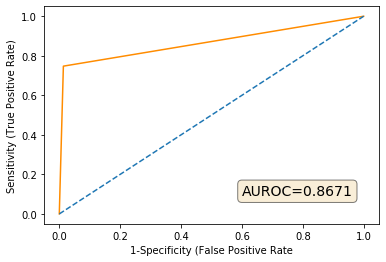

AUROC score is 0.8671


In [9]:
from logregression import roc_auroc #this function draws ROC curve and returns AUROC value

# Draw ROC curve
print('AUROC score is {:.4f}'. format(roc_auroc(gbtm_preds,y_test)))

Note that GBT model provides a superior AUROC score compared to Logistic Regression model.

Let us investigate importance of each variable for explaining default risk

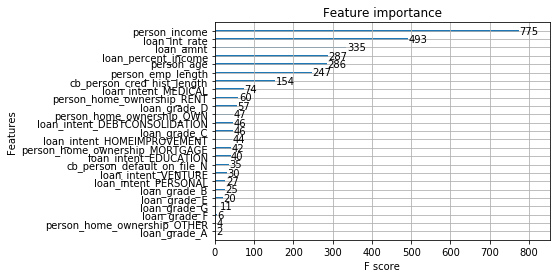

('person_income', 775)
('loan_int_rate', 493)
('loan_amnt', 335)
('loan_percent_income', 287)
('person_age', 286)
('person_emp_length', 247)
('cb_person_cred_hist_length', 154)
('loan_intent_MEDICAL', 74)
('person_home_ownership_RENT', 60)
('loan_grade_D', 57)
('person_home_ownership_OWN', 47)
('loan_grade_C', 46)
('loan_intent_DEBTCONSOLIDATION', 46)
('loan_intent_HOMEIMPROVEMENT', 44)
('person_home_ownership_MORTGAGE', 42)
('loan_intent_EDUCATION', 40)
('cb_person_default_on_file_N', 35)
('loan_intent_VENTURE', 30)
('loan_intent_PERSONAL', 27)
('loan_grade_B', 25)
('loan_grade_E', 20)
('loan_grade_G', 11)
('loan_grade_F', 6)
('person_home_ownership_OTHER', 4)
('loan_grade_A', 2)
100


In [10]:
weights=sorted(gbtm.get_booster().get_score(importance_type="weight").items(), key=lambda x: x[1], reverse=True)
xgb.plot_importance(gbtm, importance_type='weight')
plt.show()
for item in weights: print(item)

print(len(gbtm.get_booster().get_dump()))

The analysis above suggests that 
<br>
person_income,loan_int_rate, loan_amnt, loan_percent_income, person_age, person_emp_length and cb_person_cred_hist_length<br>
are by far the most important factors explaining probability of default.

Compare perfromance of the initial model to the reduced model where only top-7 explanatory variables are used.

In [11]:
X_train1=pd.concat([X_train['person_income'], X_train['loan_int_rate'],X_train['loan_amnt'], 
                    X_train['loan_percent_income'],X_train['person_age'], X_train['person_emp_length'],
                   X_train['cb_person_cred_hist_length']],axis=1)

X_test1=pd.concat([X_test['person_income'], X_test['loan_int_rate'],X_test['loan_amnt'], 
                    X_test['loan_percent_income'],X_test['person_age'], X_test['person_emp_length'],
                   X_test['cb_person_cred_hist_length']],axis=1)

gbtm1=xgb.XGBClassifier().fit(X_train1, np.ravel(y_train))

gbtm1_preds=gbtm1.predict(X_test1)

target_names=['Non-Default', 'Default']
print(classification_report(y_test, gbtm1_preds, target_names=target_names))

#Calculate accuracy of the model
print('Mean accuracy score is {:.4f}'.format(gbtm1.score(X_test1,y_test)))

              precision    recall  f1-score   support

 Non-Default       0.90      0.94      0.92      9229
     Default       0.75      0.64      0.69      2555

    accuracy                           0.88     11784
   macro avg       0.83      0.79      0.81     11784
weighted avg       0.87      0.88      0.87     11784

Mean accuracy score is 0.8766


Notably, when all explanatory variables is used accuracy is improved by 0.06 and Default f1-score is improved by 0.14.
Therefore, we will use full model for the following business case study.

[[to top]](#top)<br>
<h2><a id="Business-case">Business Case</a></h2><br>
Let us use GBT model to run a simple cost-benefit analysis. Since loan duration data is not available in the sample, let us assume that all loans have maturity of 10 years. Assume also that the future discounts at 2%

First let us calculate gains and losses from doing nothing. As such, assume that all non-default loans in the test sample will be ammortized equally over 10 years and a corresponding interest will be paid on the outstanding amount. Assume further that all defaulted loans in the test sample default immediately and no debt is recovered.

In [12]:
X_test1=X_test.reset_index()
y_test1=y_test.reset_index()
data_test=pd.concat([X_test1,y_test1],axis=1)

def revenue(amt, loan_int):
    revenue=0
    for i in range(10):
        revenue+=(1-i/10)*amt*loan_int*0.01/(1.02**i)
    return(revenue)

data_test['revenue']=-data_test['loan_amnt']*data_test['loan_status']\
+(1-data_test['loan_status'])*revenue(data_test['loan_amnt'], data_test['loan_int_rate'])

print('Expected net profit without model-induced decision-making is {:.1f}M'
      .format(0.000001*data_test['revenue'].sum()))

Expected net profit without model-induced decision-making is 19.7M


Hence, if a predictive model is not used, a firm wil make 19.6M profit if it approves all the loans.

Suppose we apply model based on the threshold of 0.27.
There are three possible outcomes depicted by the following tree:

Loan is approved? YES Creditor defaults? YES Loan amount is lost<br>
Loan is approved? YES Creditor defaults? NO Interest revenue received<br>
Loan is approved? NO Zero revenue is received<br>
                    
Loan is approved if no default is expected (predicted probability of default is less that threshold) and is rejected otherwise.
Creditor defaults if true 'loan_status' is 1 and does not default otherwise.

Let us model this on the test data

In [13]:
df=pd.concat([data_test['revenue'].reset_index(drop=True),
              pd.DataFrame(gbtm_preds, columns=['pred_loan_status'])],axis=1)

print('Expected net profit with GBT model-induced decision-making is {:.1f}M'
      .format(0.000001*((1-df['pred_loan_status'])*df['revenue']).sum()))

Expected net profit with GBT model-induced decision-making is 41.1M


GBT model allowed more than doubling profit on the test sample, which is favourably compared with the Logistic model performance which allowed for a maximum of 29.4M net profit.<br>
[[to top]](#top)<br><br>